In [53]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import os
from nixtlats import TimeGPT
import seaborn as sns

In [2]:
tickers=['XLY','HD','NKE',
         'XLP','CL','EL','KO','PEP',
         'XLE','APA','OXY',
         'XLF','WFC','GS','BLK',
         'XLV','PFE','HUM',
         'XLI','FDX','GD',
         'XLB','ECL',
         'XLU','DTE']

stock_names=['HD','NKE',
        'CL','EL','KO','PEP',
        'APA','OXY',
        'WFC','GS','BLK',
        'PFE','HUM',
        'FDX','GD',
        'ECL','DTE']

match = {"XLY": ["HD", "NKE"],
         "XLP": ["CL", "EL", "KO", "PEP"],
         "XLE": ["APA", "OXY"],
         "XLF": ["WFC", "GS", "BLK"],
         "XLV": ["PFE", "HUM"],
         "XLI": ["FDX", "GD"],
         "XLB": ["ECL"],
         "XLU": ["DTE"]}

In [4]:
data_dict = {key: pdr.get_data_yahoo(key, start="2000-01-01", end="2023-11-01") for key in tickers}

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [5]:
def get_returns(stks):
    stks['close2open']=np.log(stks['Close']/stks['Open'])
    stks=stks.reset_index()
    stks=stks.rename(columns={"Date": "timestamp"})
    df_2=pd.DataFrame(columns=['timestamp', 'value'])
    df_2['timestamp']=stks['timestamp']
    df_2['value']=stks['close2open']
    return df_2


def create_df_split(df,start_date,end_date):
    l_dfs=[]
    df_full=pd.DataFrame()
    df=df[(df['timestamp']>start_date)&(df['timestamp']<end_date)]
    df.reset_index(inplace=True)
    num_data_points=df.shape[0]
    size_df=144
    for i in range(num_data_points):
        df_tr=df.iloc[i:i+size_df, :].copy(deep=True)
        df_tr['unique_id']=i
        l_dfs.append(df_tr)
    for df_item in l_dfs:
        df_full=pd.concat([df_full,df_item], axis=0)
    df_full.reset_index(inplace=True)
    df_full.drop(columns=['level_0'], inplace=True)
    df_full.drop(columns=['index'], inplace=True)
    df_full_2=df_full[['timestamp', 'value_diff', 'unique_id']]
    df_full_2=df_full_2.rename(columns={"value_diff": "value"})

    return df_full_2

In [6]:
r_dict = {}
for k in match.keys():
    stocks = match[k]
    etf = data_dict[k]
    df_etf = get_returns(etf)
    for stock in stocks:
        stks = data_dict[stock]
        df_stks = get_returns(stks)
        df_comb = pd.merge(df_etf, df_stks, on="timestamp")
        df_comb["value_diff"] = df_comb["value_y"] - df_comb["value_x"]
        df_comb.rename(columns={"value_x": "etf_r", "value_y": "stock_r"}, inplace=True)
        r_dict[stock] = df_comb

In [7]:
os.environ['TIMEGPT_TOKEN'] = 'get your token from https://api.nixtlats.ai/'

In [10]:
timegpt = TimeGPT(token=os.environ['TIMEGPT_TOKEN'])

In [ ]:
output=[]
for st in stock_names:
  stock_m=r_dict[st]
  start='2014-06-08'
  end='2015-12-31'
  stock_m_split=create_df_split(stock_m, start, end)
  stock_m_split_2=stock_m_split[stock_m_split['unique_id']<252]
  fcst_stock_m_2015 = timegpt.forecast(stock_m_split_2,
                                    h=1,
                                    freq='B',
                                    time_col='timestamp',
                                    target_col='value')
  fcst_stock_m_2015['timestamp']=pd.to_datetime(fcst_stock_m_2015['timestamp'])
  fcst_stock_m_2015=fcst_stock_m_2015.rename(columns={"timestamp": "ts_tgpt"})
  fcst_stock_m_2015['timestamp']=stock_m[(stock_m['timestamp']>'2014-12-31')&(stock_m['timestamp']<='2015-12-31')].timestamp.to_list()
  stock_m_comb = pd.merge(fcst_stock_m_2015, stock_m, on="timestamp")
  stock_m_final=stock_m_comb[['timestamp','etf_r', 'stock_r', 'value_diff','TimeGPT']]
  stock_m_final['sign'] = np.where(stock_m_final['TimeGPT']>0, 1, -1)
  stock_m_final['PnL']=stock_m_final.sign*stock_m_final.value_diff
  output.append(stock_m_final)

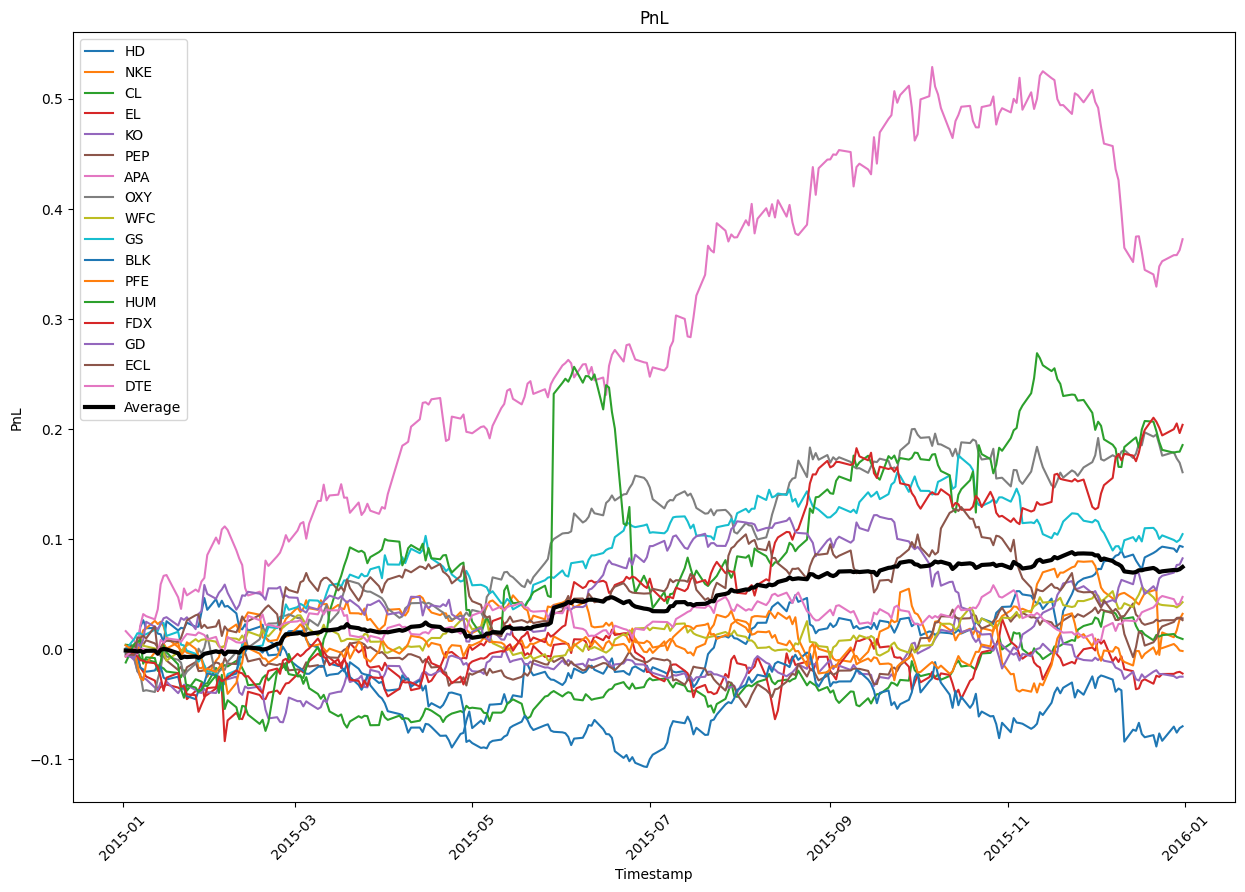

In [50]:
plt.figure(figsize=(15,10))
PnL_average = []

for stock, value in zip(stock_names, output):
    # value.set_index('timestamp', inplace=True)
    plt.plot(value['PnL'].cumsum(), label=stock)
    PnL_average.append(value['PnL'].cumsum())
PnL_average = np.array(PnL_average).sum(axis=0) / len(PnL_average)
df_average=pd.DataFrame(PnL_average, columns=['PnL'])
df_average.set_index(value.index, inplace=True)
plt.plot(df_average['PnL'], label='Average', linewidth=3, color='black')
# plt.xticks(np.arange(0, len(value), step=10))
plt.xticks(rotation=45)
plt.title('PnL')
plt.xlabel('Timestamp')
plt.ylabel('PnL')
# show labels
plt.legend(loc='upper left')
plt.show()

In [51]:
SR_l={}
for k, otp in zip(stock_names, output):
  sr=252*otp['PnL'].mean()/((((otp['PnL']-otp['PnL'].mean())**2).sum())**0.5)
  SR_l[k] = sr

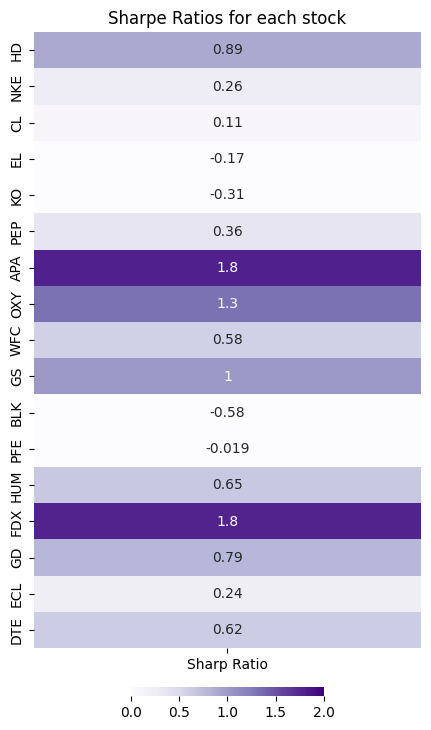

In [55]:
plt.figure(figsize=(5,10))
sns.heatmap(pd.DataFrame(SR_l, index=["Sharp Ratio"]).T, cmap='Purples', annot=True, vmin=0, vmax=2, cbar_kws={"orientation": "horizontal", "shrink": 0.5, "pad": 0.05})
plt.title('Sharpe Ratios for each stock')
plt.show()

In [56]:
all_stocks=pd.DataFrame()
for ind, s in enumerate(stock_names):
  all_stocks[s]=output[ind]['PnL']
all_stocks['sum'] = all_stocks.sum(axis=1)
sr_portfolio=252*all_stocks['sum'].mean()/((((all_stocks['sum']-all_stocks['sum'].mean())**2).sum())**0.5)

In [57]:
print(f'Portfolio annual Sharpe ratio for 2015: {sr_portfolio:.2f}')

Portfolio annual Sharpe ratio for 2015: 2.32
